# Training Model: Cnn + wavelets transform

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!pip install obspy

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from obspy import read
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [12]:
base_path = '/content/gdrive/MyDrive'

train_augmented_data_path = f'{base_path}/Notebooks/SeismicWaves/training_augmented/augmented'
train_ranges_data_path = f'{base_path}/Notebooks/SeismicWaves/training_augmented/augmented_ranges'
train_data_path = f'{base_path}/Notebooks/SeismicWaves/training_augmented/train'
val_data_path = f'{base_path}/Notebooks/SeismicWaves/training_augmented/val'
test_data_path = f'{base_path}/Notebooks/SeismicWaves/training_augmented/testing'
features_path = f'{base_path}/Notebooks/SeismicWaves/procesing'

In [ ]:

def analyze_signal_lengths(data_path):
    """
    Analiza las longitudes de las señales en un directorio.

    Args:
        data_path: Ruta al directorio con archivos MSEED

    Returns:
        dict: Estadísticas de longitud de señales
    """
    lengths = []
    files_df = pd.read_csv(os.path.join(data_path, "feature_files.csv"))

    print(f"Analizando señales en {data_path}...")
    for file in tqdm(files_df["file"]):
        file_path = os.path.join(data_path, file)
        try:
            st = read(file_path)
            signal_length = len(st[0].data)
            lengths.append(signal_length)
        except Exception as e:
            print(f"Error procesando {file}: {str(e)}")
            continue

    stats = {
        "min_length": min(lengths),
        "max_length": max(lengths),
        "mean_length": np.mean(lengths),
        "median_length": np.median(lengths),
        "std_length": np.std(lengths),
        "p95_length": np.percentile(lengths, 95),
        "num_signals": len(lengths),
    }

    return stats, lengths



Analizando señales en /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/train...


100%|██████████| 1663/1663 [10:34<00:00,  2.62it/s]


Analizando señales en /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/val...


100%|██████████| 317/317 [00:05<00:00, 60.36it/s]


Analizando señales en /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/testing...


100%|██████████| 496/496 [00:08<00:00, 57.02it/s]



Estadísticas de longitud de señales:

Conjunto de entrenamiento:
min_length: 2981.00
max_length: 23701.00
mean_length: 7272.59
median_length: 7201.00
std_length: 798.00
p95_length: 8401.00
num_signals: 1663.00

Conjunto de validación:
min_length: 3963.00
max_length: 10001.00
mean_length: 7334.65
median_length: 7201.00
std_length: 698.32
p95_length: 8601.00
num_signals: 317.00

Conjunto de prueba:
min_length: 3600.00
max_length: 18201.00
mean_length: 7288.48
median_length: 7201.00
std_length: 821.88
p95_length: 8401.00
num_signals: 496.00


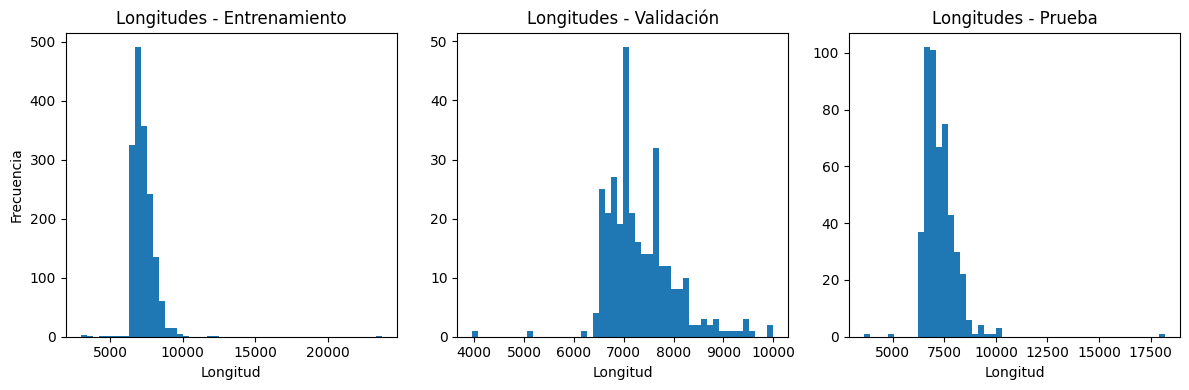

In [ ]:

# Analizar cada conjunto de datos
train_stats, train_lengths = analyze_signal_lengths(train_data_path)
val_stats, val_lengths = analyze_signal_lengths(val_data_path)
test_stats, test_lengths = analyze_signal_lengths(test_data_path)

# Mostrar resultados
print("\nEstadísticas de longitud de señales:")
print("\nConjunto de entrenamiento:")
for key, value in train_stats.items():
    print(f"{key}: {value:.2f}")

print("\nConjunto de validación:")
for key, value in val_stats.items():
    print(f"{key}: {value:.2f}")

print("\nConjunto de prueba:")
for key, value in test_stats.items():
    print(f"{key}: {value:.2f}")

# Visualizar distribución de longitudes
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.hist(train_lengths, bins=50)
plt.title("Longitudes - Entrenamiento")
plt.xlabel("Longitud")
plt.ylabel("Frecuencia")

plt.subplot(132)
plt.hist(val_lengths, bins=50)
plt.title("Longitudes - Validación")
plt.xlabel("Longitud")

plt.subplot(133)
plt.hist(test_lengths, bins=50)
plt.title("Longitudes - Prueba")
plt.xlabel("Longitud")

plt.tight_layout()
plt.show()

In [5]:

def pad_or_trim(signal, target_length=8000):
    if len(signal) > target_length:
        return signal[:target_length]
    elif len(signal) < target_length:
        pad_width = target_length - len(signal)
        return np.pad(signal, (0, pad_width), mode='constant')
    return signal

# ------------------- Funciones de Carga -------------------
def load_data(data_path):
    # Cargar señales crudas
    raw_signals = []
    files_df = pd.read_csv(os.path.join(data_path, 'feature_files.csv'))
    print(f'Cargando señales desde {data_path}...')
    for file in tqdm(files_df['file']):
        file_path = os.path.join(data_path, file)
        st = read(file_path)
        signal = st[0].data
        signal = pad_or_trim(signal, target_length=8000)
        raw_signals.append(signal)

    X_raw = np.array(raw_signals)
    X_raw = X_raw.reshape(X_raw.shape[0], -1, 1)  # Añadir dimensión para CNN

    # Cargar características wavelets
    X_wavelets = np.load(os.path.join(data_path, 'wavelet_features.npy'))

    # Cargar tiempos de llegada
    y = np.load(os.path.join(data_path, 'arrival_times.npy'))

    return X_raw, X_wavelets, y, files_df

### Augmented data v1

In [ ]:


# ------------------- Carga de Datos -------------------
X_raw_train, X_wavelets_train, y_train, train_files = load_data(train_augmented_data_path)
X_raw_val, X_wavelets_val, y_val, val_files = load_data(val_data_path)
X_raw_test, X_wavelets_test, y_test, test_files = load_data(test_data_path)

print('Formas:')
print(f'Entrenamiento señales crudas: {X_raw_train.shape}')
print(f'Validación señales crudas: {X_raw_val.shape}')
print(f'Prueba señales crudas: {X_raw_test.shape}')

Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/augmented...


100%|██████████| 4989/4989 [01:29<00:00, 55.44it/s]


Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/val...


100%|██████████| 317/317 [00:05<00:00, 57.88it/s]


Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/testing...


100%|██████████| 496/496 [00:09<00:00, 54.62it/s]

Formas:
Entrenamiento señales crudas: (4989, 8000, 1)
Validación señales crudas: (317, 8000, 1)
Prueba señales crudas: (496, 8000, 1)


In [8]:
# ------------------- Creación del Modelo -------------------
def create_model(input_shape_raw, input_shape_wavelets):
    raw_input = tf.keras.layers.Input(shape=input_shape_raw)
    x1 = tf.keras.layers.BatchNormalization()(raw_input)
    x1 = tf.keras.layers.Conv1D(32, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    x1 = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    x1 = tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)

    wavelet_input = tf.keras.layers.Input(shape=input_shape_wavelets)
    x2 = tf.keras.layers.BatchNormalization()(wavelet_input)
    x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Dropout(0.3)(x2)

    combined = tf.keras.layers.concatenate([x1, x2])

    x = tf.keras.layers.Dense(256, activation='relu')(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    output = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[raw_input, wavelet_input], outputs=output)
    return model

In [ ]:


input_shape_raw = (8000, 1)
input_shape_wavelets = (X_wavelets_train.shape[1],)

model = create_model(input_shape_raw, input_shape_wavelets)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='huber', metrics=['mae', 'mse'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 8000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8000, 1)   │          4 │ input_layer_6[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 8000, 32)  │        192 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8000, 32)  │        128 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 4000, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 4000, 64)  │     10,304 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4000, 64)  │        256 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 2000, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60)        │        240 │ input_layer_7[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 2000, 128) │     41,088 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │      7,808 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 128) │        512 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │     65,792 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 161,397 (630.46 KB)

 Trainable params: 159,803 (624.23 KB)

 Non-trainable params: 1,594 (6.23 KB)

In [ ]:
# ------------------- Callbacks -------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-6, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath='v1augmeted_model.keras', monitor='val_mae', save_best_only=True, mode='min')
]

# ------------------- Entrenamiento -------------------
history = model.fit(
    [X_raw_train, X_wavelets_train],
    y_train,
    validation_data=([X_raw_val, X_wavelets_val], y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - loss: 29.3763 - mae: 29.8763 - mse: 916.9236 - val_loss: 27.0900 - val_mae: 27.5900 - val_mse: 773.6484 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 27.3055 - mae: 27.8053 - mse: 799.2492 - val_loss: 22.3404 - val_mae: 22.8404 - val_mse: 534.0847 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 22.2264 - mae: 22.7262 - mse: 561.5944 - val_loss: 12.8110 - val_mae: 13.3109 - val_mse: 188.9848 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 13.1690 - mae: 13.6663 - mse: 229.7772 - val_loss: 2.5908 - val_mae: 3.0523 - val_mse: 23.5970 - learning_rate: 0.0010
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 4.7834 - mae: 5.2597 - mse: 50.5782 - val_loss: 1.1334 - val_mae: 1.5179 - val_mse: 14.4524 - learning_rate: 0.0010
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 3.6988 - mae: 4.1651 - mse: 35.4396

In [ ]:
# ------------------- Evaluación -------------------
print('Realizando predicciones en conjunto de prueba...')
y_pred = model.predict([X_raw_test, X_wavelets_test])

# Guardar resultados
results_df = pd.DataFrame({
    'file': test_files['file'],
    'real_time': y_test,
    'predicted_time': y_pred.flatten(),
    'error': y_pred.flatten() - y_test
})
results_df['abs_error'] = np.abs(results_df['error'])
results_df = results_df.sort_values('abs_error', ascending=False)

results_df.to_csv(os.path.join(features_path, 'v1augmented_evaluation.csv'), index=False)


Realizando predicciones en conjunto de prueba...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [ ]:
# ------------------- Métricas Finales -------------------
print('\nMétricas de rendimiento en conjunto de prueba:')
mae = np.mean(np.abs(results_df['error']))
rmse = np.sqrt(np.mean(results_df['error']**2))
max_error = np.max(results_df['abs_error'])

print(f'MAE: {mae:.4f} segundos')
print(f'RMSE: {rmse:.4f} segundos')
print(f'Máximo error: {max_error:.4f} segundos')


Métricas de rendimiento en conjunto de prueba:
MAE: 0.6670 segundos
RMSE: 2.7765 segundos
Máximo error: 30.5010 segundos


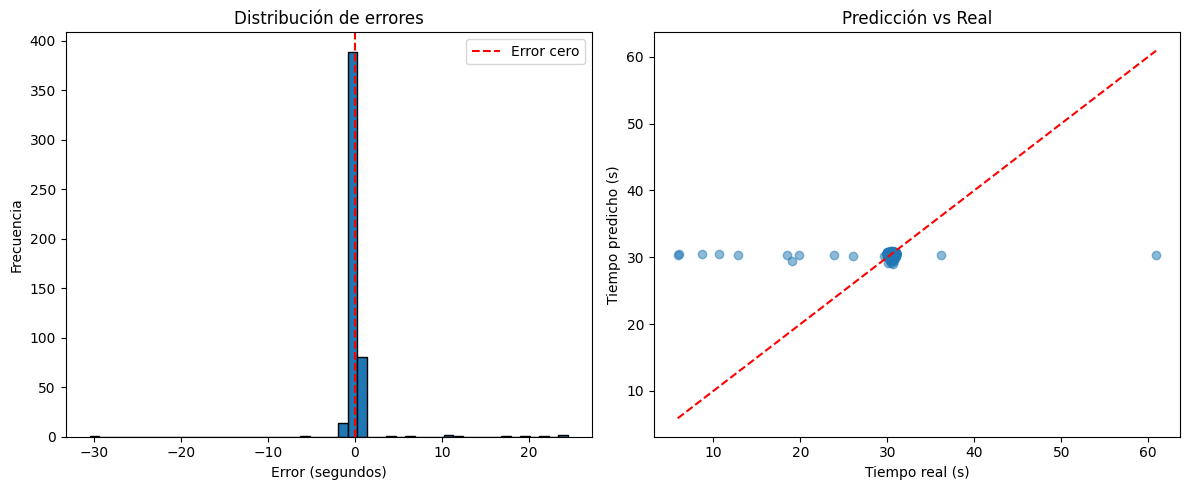


Estadísticas de errores:
Error medio: 0.1790 segundos
Desviación estándar: 2.7707 segundos
Mediana del error: -0.0163 segundos
Error dentro de ±0.5s: 82.3%
Error dentro de ±1.0s: 96.0%


In [ ]:
# ------------------- Visualización -------------------
errors = y_pred.flatten() - y_test

plt.figure(figsize=(12, 5))

# Histograma de errores
plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Distribución de errores')
plt.xlabel('Error (segundos)')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--', label='Error cero')
plt.legend()

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred.flatten(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Tiempo real (s)')
plt.ylabel('Tiempo predicho (s)')
plt.title('Predicción vs Real')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print('\nEstadísticas de errores:')
print(f'Error medio: {np.mean(errors):.4f} segundos')
print(f'Desviación estándar: {np.std(errors):.4f} segundos')
print(f'Mediana del error: {np.median(errors):.4f} segundos')
print(f'Error dentro de ±0.5s: {100*np.mean(np.abs(errors) < 0.5):.1f}%')
print(f'Error dentro de ±1.0s: {100*np.mean(np.abs(errors) < 1.0):.1f}%')

### Original data

In [ ]:
# ------------------- Carga de Datos -------------------
X_raw_train, X_wavelets_train, y_train, train_files = load_data(train_data_path)
X_raw_val, X_wavelets_val, y_val, val_files = load_data(val_data_path)
X_raw_test, X_wavelets_test, y_test, test_files = load_data(test_data_path)

print('Formas:')
print(f'Entrenamiento señales crudas: {X_raw_train.shape}')
print(f'Validación señales crudas: {X_raw_val.shape}')
print(f'Prueba señales crudas: {X_raw_test.shape}')

# ------------------- Creación del Modelo -------------------
def create_model(input_shape_raw, input_shape_wavelets):
    raw_input = tf.keras.layers.Input(shape=input_shape_raw)
    x1 = tf.keras.layers.BatchNormalization()(raw_input)
    x1 = tf.keras.layers.Conv1D(32, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    x1 = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    x1 = tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)

    wavelet_input = tf.keras.layers.Input(shape=input_shape_wavelets)
    x2 = tf.keras.layers.BatchNormalization()(wavelet_input)
    x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Dropout(0.3)(x2)

    combined = tf.keras.layers.concatenate([x1, x2])

    x = tf.keras.layers.Dense(256, activation='relu')(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    output = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[raw_input, wavelet_input], outputs=output)
    return model

In [ ]:


input_shape_raw = (8000, 1)
input_shape_wavelets = (X_wavelets_train.shape[1],)

model = create_model(input_shape_raw, input_shape_wavelets)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='huber', metrics=['mae', 'mse'])
model.summary()

# ------------------- Callbacks -------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-6, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath='normal_data.keras', monitor='val_mae', save_best_only=True, mode='min')
]

# ------------------- Entrenamiento -------------------
history = model.fit(
    [X_raw_train, X_wavelets_train],
    y_train,
    validation_data=([X_raw_val, X_wavelets_val], y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/train...


100%|██████████| 1663/1663 [13:07<00:00,  2.11it/s]


Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/val...


100%|██████████| 317/317 [00:05<00:00, 58.84it/s]


Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/testing...


100%|██████████| 496/496 [00:08<00:00, 57.12it/s]


Formas:
Entrenamiento señales crudas: (1663, 8000, 1)
Validación señales crudas: (317, 8000, 1)
Prueba señales crudas: (496, 8000, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 8000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8000, 1)   │          4 │ input_layer_2[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 8000, 32)  │        192 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8000, 32)  │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 4000, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 4000, 64)  │     10,304 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4000, 64)  │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 2000, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60)        │        240 │ input_layer_3[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 2000, 128) │     41,088 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      7,808 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 128) │        512 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │     65,792 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_5[0][0]   

 Total params: 161,397 (630.46 KB)

 Trainable params: 159,803 (624.23 KB)

 Non-trainable params: 1,594 (6.23 KB)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step - loss: 29.6715 - mae: 30.1715 - mse: 919.8791 - val_loss: 29.8531 - val_mae: 30.3531 - val_mse: 934.3795 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 29.1605 - mae: 29.6605 - mse: 888.3253 - val_loss: 28.8522 - val_mae: 29.3518 - val_mse: 874.6226 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 28.6369 - mae: 29.1369 - mse: 861.4120 - val_loss: 28.0212 - val_mae: 28.5190 - val_mse: 826.4840 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 27.8616 - mae: 28.3616 - mse: 814.9061 - val_loss: 26.7426 - val_mae: 27.2426 - val_mse: 754.4618 - learning_rate: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 26.8205 - mae: 27.3204 - mse: 756.0812 - val_loss: 25.2641 - val_mae: 25.7642 - val_mse: 675.5181 - learning_rate: 0.0010
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 25.3823 - mae: 25.8819 - mse

In [ ]:
# ------------------- Evaluación -------------------
print('Realizando predicciones en conjunto de prueba...')
y_pred = model.predict([X_raw_test, X_wavelets_test])

# Guardar resultados
results_df = pd.DataFrame({
    'file': test_files['file'],
    'real_time': y_test,
    'predicted_time': y_pred.flatten(),
    'error': y_pred.flatten() - y_test
})
results_df['abs_error'] = np.abs(results_df['error'])
results_df = results_df.sort_values('abs_error', ascending=False)

results_df.to_csv(os.path.join(features_path, 'normal_results.csv'), index=False)


Realizando predicciones en conjunto de prueba...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [ ]:
# ------------------- Métricas Finales -------------------
print('\nMétricas de rendimiento en conjunto de prueba:')
mae = np.mean(np.abs(results_df['error']))
rmse = np.sqrt(np.mean(results_df['error']**2))
max_error = np.max(results_df['abs_error'])

print(f'MAE: {mae:.4f} segundos')
print(f'RMSE: {rmse:.4f} segundos')
print(f'Máximo error: {max_error:.4f} segundos')


Métricas de rendimiento en conjunto de prueba:
MAE: 0.6864 segundos
RMSE: 2.7813 segundos
Máximo error: 30.4372 segundos


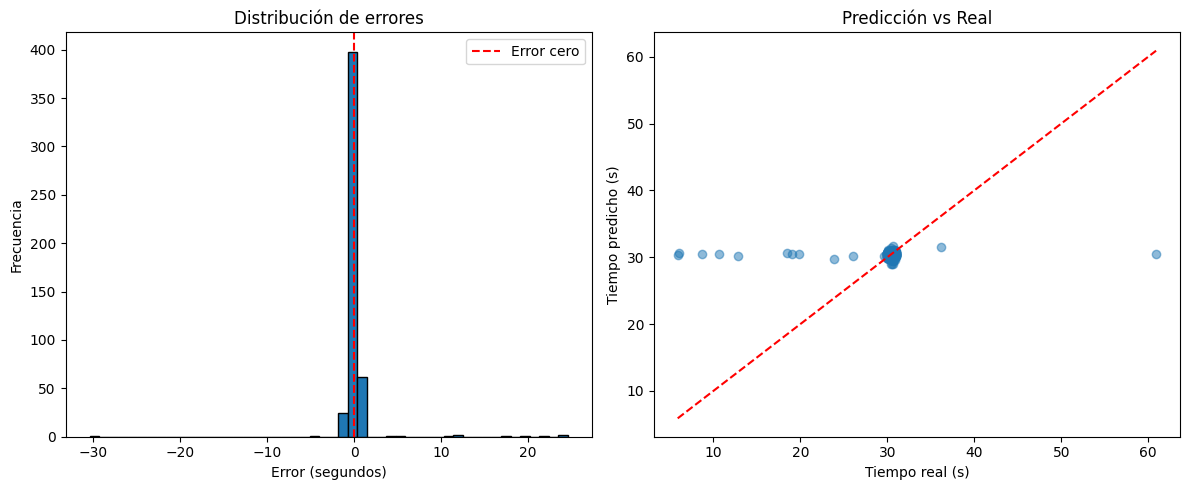


Estadísticas de errores:
Error medio: 0.1622 segundos
Desviación estándar: 2.7765 segundos
Mediana del error: -0.0497 segundos
Error dentro de ±0.5s: 78.2%
Error dentro de ±1.0s: 95.8%


In [ ]:
# ------------------- Visualización -------------------
errors = y_pred.flatten() - y_test

plt.figure(figsize=(12, 5))

# Histograma de errores
plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Distribución de errores')
plt.xlabel('Error (segundos)')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--', label='Error cero')
plt.legend()

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred.flatten(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Tiempo real (s)')
plt.ylabel('Tiempo predicho (s)')
plt.title('Predicción vs Real')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print('\nEstadísticas de errores:')
print(f'Error medio: {np.mean(errors):.4f} segundos')
print(f'Desviación estándar: {np.std(errors):.4f} segundos')
print(f'Mediana del error: {np.median(errors):.4f} segundos')
print(f'Error dentro de ±0.5s: {100*np.mean(np.abs(errors) < 0.5):.1f}%')
print(f'Error dentro de ±1.0s: {100*np.mean(np.abs(errors) < 1.0):.1f}%')

### Ranges augmented data, v1 model

In [14]:
# ------------------- Carga de Datos -------------------
X_raw_train, X_wavelets_train, y_train, train_files = load_data(train_ranges_data_path)
X_raw_val, X_wavelets_val, y_val, val_files = load_data(val_data_path)
X_raw_test, X_wavelets_test, y_test, test_files = load_data(test_data_path)

print('Formas:')
print(f'Entrenamiento señales crudas: {X_raw_train.shape}')
print(f'Validación señales crudas: {X_raw_val.shape}')
print(f'Prueba señales crudas: {X_raw_test.shape}')

Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/augmented_ranges...


100%|██████████| 5940/5940 [1:15:08<00:00,  1.32it/s]


Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/val...


100%|██████████| 317/317 [03:40<00:00,  1.44it/s]


Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/testing...


100%|██████████| 496/496 [05:56<00:00,  1.39it/s]


Formas:
Entrenamiento señales crudas: (5940, 8000, 1)
Validación señales crudas: (317, 8000, 1)
Prueba señales crudas: (496, 8000, 1)


In [15]:

input_shape_raw = (8000, 1)
input_shape_wavelets = (X_wavelets_train.shape[1],)

model = create_model(input_shape_raw, input_shape_wavelets)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='huber', metrics=['mae', 'mse'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 8000, 1)   │          4 │ input_layer[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 8000, 32)  │        192 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8000, 32)  │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 4000, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 4000, 64)  │     10,304 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4000, 64)  │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 2000, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60)        │        240 │ input_layer_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2000, 128) │     41,088 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      7,808 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 128) │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]   

 Total params: 161,397 (630.46 KB)

 Trainable params: 159,803 (624.23 KB)

 Non-trainable params: 1,594 (6.23 KB)

In [16]:

# ------------------- Callbacks -------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-6, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath='augmented_ranges_huber_data.keras', monitor='val_mae', save_best_only=True, mode='min')
]

# ------------------- Entrenamiento -------------------
history = model.fit(
    [X_raw_train, X_wavelets_train],
    y_train,
    validation_data=([X_raw_val, X_wavelets_val], y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 176ms/step - loss: 29.3437 - mae: 29.8424 - mse: 1090.6622 - val_loss: 28.0413 - val_mae: 28.5401 - val_mse: 827.3677 - learning_rate: 0.0010
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - loss: 26.8386 - mae: 27.3353 - mse: 939.2739 - val_loss: 20.3293 - val_mae: 20.8293 - val_mse: 443.9738 - learning_rate: 0.0010
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 20.9118 - mae: 21.4076 - mse: 627.4357 - val_loss: 11.3529 - val_mae: 11.8516 - val_mse: 159.6410 - learning_rate: 0.0010
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 13.9951 - mae: 14.4889 - mse: 321.3628 - val_loss: 2.4371 - val_mae: 2.8844 - val_mse: 21.0958 - learning_rate: 0.0010
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 10.9127 - mae: 11.3997 - mse: 220.1279 - val_loss: 1.8010 - val_mae: 2.2411 - val_mse: 15.4871 - learning_rate: 0.0010
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 10.4443 - mae: 10.9255 - mse: 2

In [17]:
# ------------------- Evaluación -------------------
print('Realizando predicciones en conjunto de prueba...')
y_pred = model.predict([X_raw_test, X_wavelets_test])

# Guardar resultados
results_df = pd.DataFrame({
    'file': test_files['file'],
    'real_time': y_test,
    'predicted_time': y_pred.flatten(),
    'error': y_pred.flatten() - y_test
})
results_df['abs_error'] = np.abs(results_df['error'])
results_df = results_df.sort_values('abs_error', ascending=False)

results_df.to_csv(os.path.join(features_path, 'augmented_ranges_huber_data.csv'), index=False)

Realizando predicciones en conjunto de prueba...
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


In [18]:
# ------------------- Métricas Finales -------------------
print('\nMétricas de rendimiento en conjunto de prueba:')
mae = np.mean(np.abs(results_df['error']))
rmse = np.sqrt(np.mean(results_df['error']**2))
max_error = np.max(results_df['abs_error'])

print(f'MAE: {mae:.4f} segundos')
print(f'RMSE: {rmse:.4f} segundos')
print(f'Máximo error: {max_error:.4f} segundos')


Métricas de rendimiento en conjunto de prueba:
MAE: 0.6786 segundos
RMSE: 2.8132 segundos
Máximo error: 30.4912 segundos


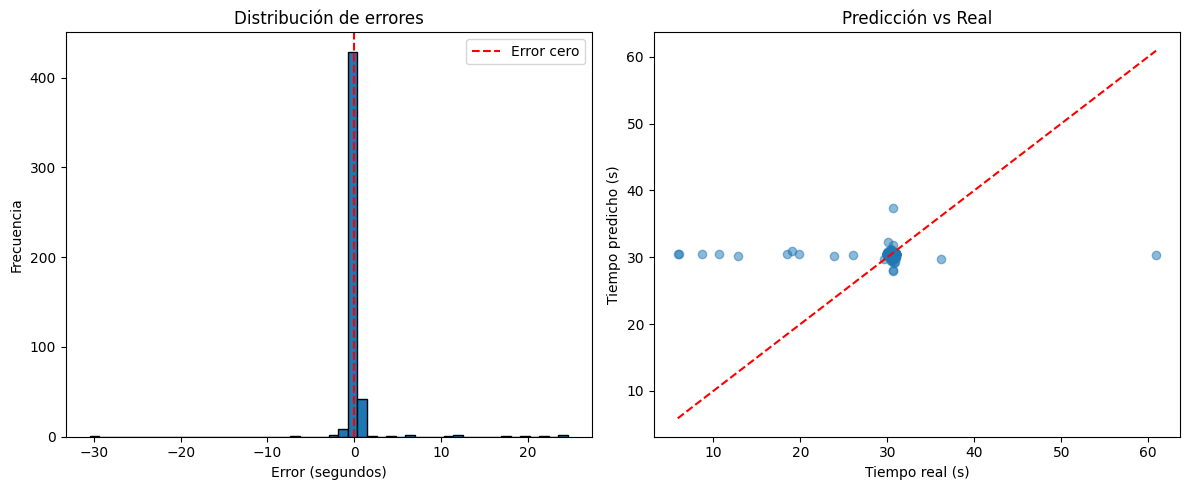


Estadísticas de errores:
Error medio: 0.1754 segundos
Desviación estándar: 2.8077 segundos
Mediana del error: -0.0529 segundos
Error dentro de ±0.5s: 85.3%
Error dentro de ±1.0s: 95.8%


In [19]:
# ------------------- Visualización -------------------
errors = y_pred.flatten() - y_test

plt.figure(figsize=(12, 5))

# Histograma de errores
plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Distribución de errores')
plt.xlabel('Error (segundos)')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--', label='Error cero')
plt.legend()

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred.flatten(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Tiempo real (s)')
plt.ylabel('Tiempo predicho (s)')
plt.title('Predicción vs Real')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print('\nEstadísticas de errores:')
print(f'Error medio: {np.mean(errors):.4f} segundos')
print(f'Desviación estándar: {np.std(errors):.4f} segundos')
print(f'Mediana del error: {np.median(errors):.4f} segundos')
print(f'Error dentro de ±0.5s: {100*np.mean(np.abs(errors) < 0.5):.1f}%')
print(f'Error dentro de ±1.0s: {100*np.mean(np.abs(errors) < 1.0):.1f}%')

In [24]:
def precision_con_tolerancia(y_true, y_pred, tolerancia_ms, sample_rate=1):
    # Convertimos la tolerancia de milisegundos a muestras
    tolerancia_muestras = int((tolerancia_ms / 1000) * sample_rate)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # True Positives: predicciones dentro de la ventana de tolerancia
    tp = np.sum(np.abs(y_true - y_pred) <= tolerancia_muestras)

    # False Positives: predicciones fuera de la ventana (pero que predijeron algo)
    fp = np.sum(np.abs(y_true - y_pred) > tolerancia_muestras)

    precision = tp / (tp + fp + 1e-10)  # para evitar división por cero
    return precision

# Asume que y_test e y_pred están en segundos
# Define tolerancias de ejemplo
tolerancias_ms = [20, 50, 100, 200, 500, 1000]  # puedes ajustar según tu aplicación

for tol in tolerancias_ms:
    prec = precision_con_tolerancia(
        y_true=y_test * 1000,       # convertir a ms
        y_pred=y_pred.flatten() * 1000,  # convertir a ms
        tolerancia_ms=tol,
        sample_rate=1000  # 1000 muestras por segundo
    )
    print(f"Precisión con tolerancia ±{tol}ms: {prec*100:.2f}%")



Precisión con tolerancia ±20ms: 5.24%
Precisión con tolerancia ±50ms: 12.10%
Precisión con tolerancia ±100ms: 19.76%
Precisión con tolerancia ±200ms: 39.52%
Precisión con tolerancia ±500ms: 85.28%


### Tunning hyperparameters

In [26]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.4 MB/s eta 0:00:00


In [27]:
import keras_tuner as kt
from tensorflow import keras

def build_model(hp):
    input_shape_raw = (8000, 1)
    input_shape_wavelets = (X_wavelets_train.shape[1],)

    raw_input = keras.layers.Input(shape=input_shape_raw)
    x1 = keras.layers.BatchNormalization()(raw_input)
    x1 = keras.layers.Conv1D(
        filters=hp.Choice('conv1_filters', [32, 64, 128]),
        kernel_size=hp.Choice('conv1_kernel', [3, 5, 7]),
        padding='same', activation='relu')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.MaxPooling1D(2)(x1)
    x1 = keras.layers.Conv1D(
        filters=hp.Choice('conv2_filters', [64, 128, 256]),
        kernel_size=hp.Choice('conv2_kernel', [3, 5, 7]),
        padding='same', activation='relu')(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.MaxPooling1D(2)(x1)
    x1 = keras.layers.GlobalAveragePooling1D()(x1)

    wavelet_input = keras.layers.Input(shape=input_shape_wavelets)
    x2 = keras.layers.BatchNormalization()(wavelet_input)
    x2 = keras.layers.Dense(
        units=hp.Choice('dense_wavelet_units', [64, 128, 256]),
        activation='relu')(x2)
    x2 = keras.layers.BatchNormalization()(x2)
    x2 = keras.layers.Dropout(hp.Float('dropout_wavelet', 0.2, 0.5, step=0.1))(x2)

    combined = keras.layers.concatenate([x1, x2])

    x = keras.layers.Dense(
        units=hp.Choice('dense1_units', [128, 256, 512]),
        activation='relu')(combined)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1))(x)

    x = keras.layers.Dense(
        units=hp.Choice('dense2_units', [64, 128, 256]),
        activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(hp.Float('dropout2', 0.1, 0.4, step=0.1))(x)

    output = keras.layers.Dense(1)(x)

    model = keras.Model(inputs=[raw_input, wavelet_input], outputs=output)

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='huber',
        metrics=['mae']
    )

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuner_dir',
    project_name='wavelet_tuning'
)

tuner.search_space_summary()

tuner.search(
    [X_raw_train, X_wavelets_train], y_train,
    validation_data=([X_raw_val, X_wavelets_val], y_val),
    epochs=80,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)
    ]
)


Trial 3 Complete [00h 05m 43s]
val_mae: 0.8913366198539734

Best val_mae So Far: 0.8913366198539734
Total elapsed time: 00h 20m 47s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
32                |32                |conv1_filters
7                 |5                 |conv1_kernel
128               |64                |conv2_filters
7                 |3                 |conv2_kernel
256               |128               |dense_wavelet_units
0.4               |0.2               |dropout_wavelet
256               |256               |dense1_units
0.4               |0.3               |dropout1
256               |64                |dense2_units
0.1               |0.2               |dropout2
0.00073701        |0.00074902        |learning_rate

Epoch 1/80
84/93 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 29.2404 - mae: 29.7392

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]


### Diferent Model, augmented data

In [ ]:

def create_model_v2(input_shape_raw, input_shape_wavelets):
    # Rama CNN para señales crudas
    raw_input = tf.keras.layers.Input(shape=input_shape_raw)
    x1 = tf.keras.layers.BatchNormalization()(raw_input)
    x1 = tf.keras.layers.Conv1D(64, 7, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    x1 = tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    x1 = tf.keras.layers.Conv1D(256, 3, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x1 = tf.keras.layers.Dropout(0.4)(x1)

    # Rama Wavelets
    wavelet_input = tf.keras.layers.Input(shape=input_shape_wavelets)
    x2 = tf.keras.layers.BatchNormalization()(wavelet_input)
    x2 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Dropout(0.4)(x2)
    x2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Dropout(0.3)(x2)

    # Combinación
    combined = tf.keras.layers.concatenate([x1, x2])
    x = tf.keras.layers.Dense(256, activation='relu')(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[raw_input, wavelet_input], outputs=output)
    return model

# Para usar este modelo:
input_shape_raw = (8000, 1)
input_shape_wavelets = (X_wavelets_train.shape[1],)
model = create_model_v2(input_shape_raw, input_shape_wavelets)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae', 'mse'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 8000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8000, 1)   │          4 │ input_layer_4[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 8000, 64)  │        512 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8000, 64)  │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 4000, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 4000, 128) │     41,088 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4000, 128) │        512 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60)        │        240 │ input_layer_5[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 2000, 128) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │     15,616 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 2000, 256) │     98,560 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 256) │      1,024 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 1000, 256) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     32,896 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ max_pooling1d_6[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_9[0][0]   

 Total params: 325,365 (1.24 MB)

 Trainable params: 322,811 (1.23 MB)

 Non-trainable params: 2,554 (9.98 KB)

In [ ]:
# ------------------- Callbacks -------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-6, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath='v2normal_data.keras', monitor='val_mae', save_best_only=True, mode='min')
]

# ------------------- Entrenamiento -------------------
history = model.fit(
    [X_raw_train, X_wavelets_train],
    y_train,
    validation_data=([X_raw_val, X_wavelets_val], y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 724ms/step - loss: 29.7611 - mae: 30.2344 - mse: 926.2811 - val_loss: 29.0543 - val_mae: 29.5271 - val_mse: 884.7819 - learning_rate: 5.0000e-04
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - loss: 29.5027 - mae: 29.9759 - mse: 910.9144 - val_loss: 29.3892 - val_mae: 29.8624 - val_mse: 904.7115 - learning_rate: 5.0000e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - loss: 29.4118 - mae: 29.8851 - mse: 903.2995 - val_loss: 29.4726 - val_mae: 29.9459 - val_mse: 909.6958 - learning_rate: 5.0000e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 29.1500 - mae: 29.6232 - mse: 888.7098 - val_loss: 29.2933 - val_mae: 29.7665 - val_mse: 899.0627 - learning_rate: 5.0000e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 28.9559 - mae: 29.4292 - mse: 878.6152 - val_loss: 29.3676 - val_mae: 29.8408 - val_mse: 903.5226 - learning_rate: 5.0000e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 28

In [ ]:
# ------------------- Evaluación -------------------
print('Realizando predicciones en conjunto de prueba...')
y_pred = model.predict([X_raw_test, X_wavelets_test])

# Guardar resultados
results_df = pd.DataFrame({
    'file': test_files['file'],
    'real_time': y_test,
    'predicted_time': y_pred.flatten(),
    'error': y_pred.flatten() - y_test
})
results_df['abs_error'] = np.abs(results_df['error'])
results_df = results_df.sort_values('abs_error', ascending=False)

results_df.to_csv(os.path.join(features_path, 'normal_results.csv'), index=False)

Realizando predicciones en conjunto de prueba...
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step


In [ ]:
# ------------------- Métricas Finales -------------------
print('\nMétricas de rendimiento en conjunto de prueba:')
mae = np.mean(np.abs(results_df['error']))
rmse = np.sqrt(np.mean(results_df['error']**2))
max_error = np.max(results_df['abs_error'])

print(f'MAE: {mae:.4f} segundos')
print(f'RMSE: {rmse:.4f} segundos')
print(f'Máximo error: {max_error:.4f} segundos')


Métricas de rendimiento en conjunto de prueba:
MAE: 1.0430 segundos
RMSE: 2.8681 segundos
Máximo error: 30.6216 segundos


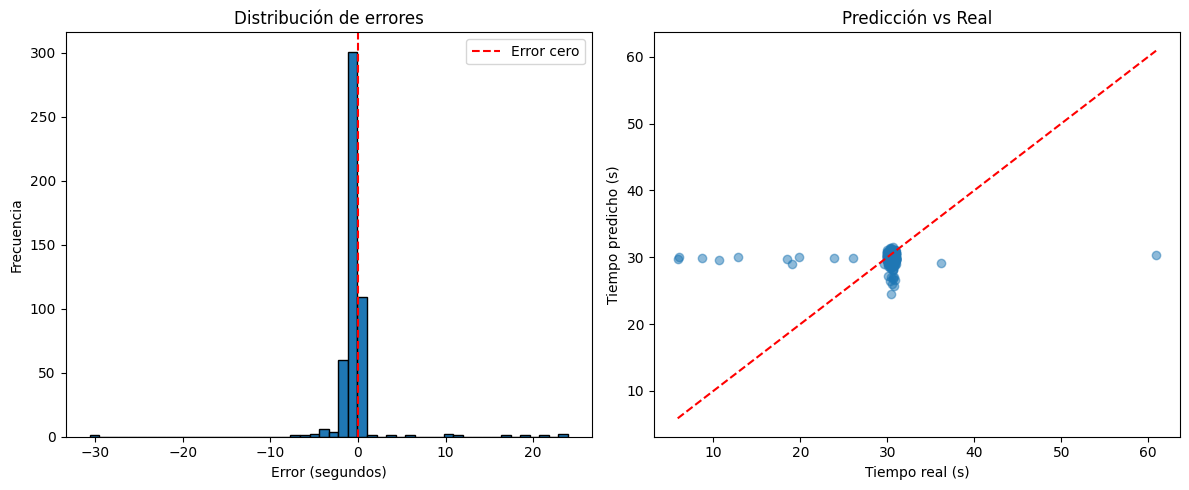


Estadísticas de errores:
Error medio: -0.3211 segundos
Desviación estándar: 2.8501 segundos
Mediana del error: -0.4715 segundos
Error dentro de ±0.5s: 45.2%
Error dentro de ±1.0s: 78.2%


In [ ]:
# ------------------- Visualización -------------------
errors = y_pred.flatten() - y_test

plt.figure(figsize=(12, 5))

# Histograma de errores
plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Distribución de errores')
plt.xlabel('Error (segundos)')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--', label='Error cero')
plt.legend()

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred.flatten(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Tiempo real (s)')
plt.ylabel('Tiempo predicho (s)')
plt.title('Predicción vs Real')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print('\nEstadísticas de errores:')
print(f'Error medio: {np.mean(errors):.4f} segundos')
print(f'Desviación estándar: {np.std(errors):.4f} segundos')
print(f'Mediana del error: {np.median(errors):.4f} segundos')
print(f'Error dentro de ±0.5s: {100*np.mean(np.abs(errors) < 0.5):.1f}%')
print(f'Error dentro de ±1.0s: {100*np.mean(np.abs(errors) < 1.0):.1f}%')

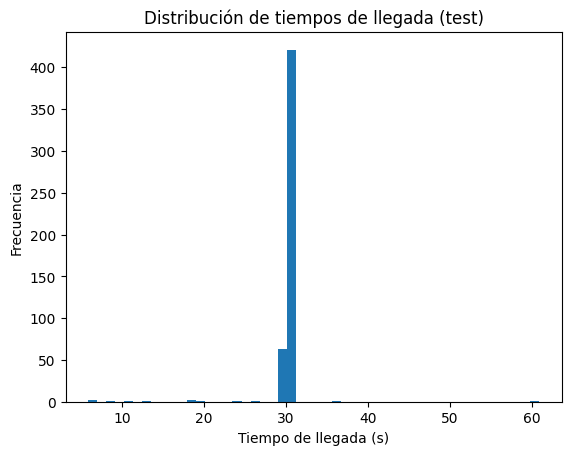

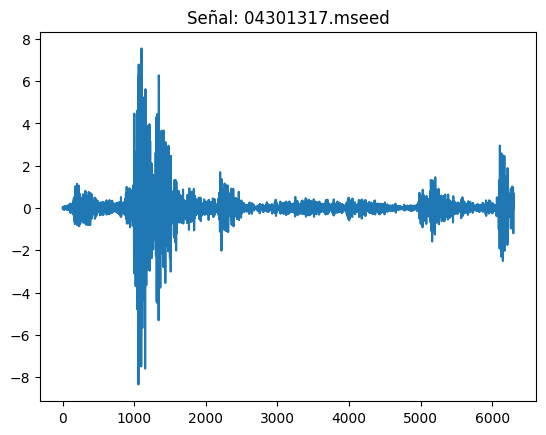

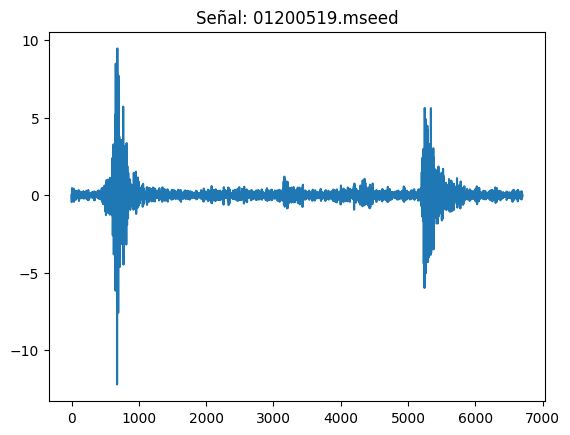

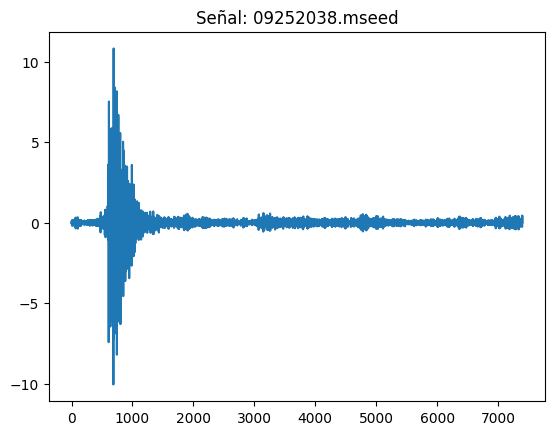

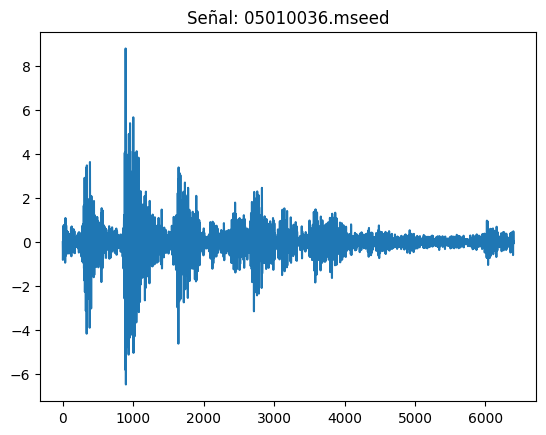

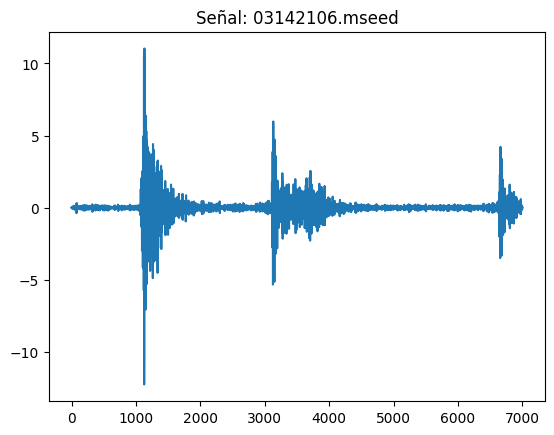

In [ ]:
# Visualiza la distribución de los tiempos de llegada
plt.hist(y_test, bins=50)
plt.title('Distribución de tiempos de llegada (test)')
plt.xlabel('Tiempo de llegada (s)')
plt.ylabel('Frecuencia')
plt.show()

# Visualiza las señales de los peores outliers
for fname in results_df.head(5)['file']:
    st = read(os.path.join(test_data_path, fname))
    plt.plot(st[0].data)
    plt.title(f'Señal: {fname}')
    plt.show()